
<script type="text/javascript" src="../_static/linksdl.js"></script>
<div class='alert alert-info'>
**This is a fixed-text formatted version of a Jupyter notebook.**

 You can contribute with your own notebooks in this
 [GitHub repository](https://github.com/gammapy/gammapy-extra/tree/master/notebooks).

**Source files:**
[spectrum_fitting_with_sherpa.ipynb](../_static/notebooks/spectrum_fitting_with_sherpa.ipynb) |
[spectrum_fitting_with_sherpa.py](../_static/notebooks/spectrum_fitting_with_sherpa.py)
</div>


# Fitting gammapy spectra with sherpa

Once we have exported the spectral files (PHA, ARF, RMF and BKG) in the OGIP format, it becomes possible to fit them later with gammapy or with any existing OGIP compliant tool such as XSpec or sherpa.

We show here how to do so with sherpa using the high-level user interface. For a general view on how to use stand-alone sherpa, see this [tutorial](http://nbviewer.jupyter.org/github/sherpa/sherpa/blob/master/docs/SherpaQuickStart.ipynb)

Tu run this notebook, one should first run spectrum_analysis to extract the relevant OGIP files.

## Importing sherpa high level UI

### loading the data as a sherpa DataStack

We first need to import the user interface and load the data with [load_data](http://cxc.harvard.edu/sherpa/ahelp/load_data.html). One can load files one by one, or more simply load them all at once through a [DataStack](http://cxc.harvard.edu/sherpa/ahelp/datastack.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import glob   # to list files
from sherpa.astro.datastack import DataStack
import sherpa.astro.datastack as sh

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
ANALYSIS_DIR = 'crab_analysis'

ds = DataStack()
pha_list = glob.glob(ANALYSIS_DIR + '/ogip_data/pha_obs*.fits')
for pha in pha_list:
    sh.load_data(ds,pha)
    
# see what is stored
ds.show_stack()

read ARF file crab_analysis/ogip_data/arf_obs23523.fits
read RMF file crab_analysis/ogip_data/rmf_obs23523.fits
read background file crab_analysis/ogip_data/bkg_obs23523.fits
read ARF file crab_analysis/ogip_data/arf_obs23526.fits
read RMF file crab_analysis/ogip_data/rmf_obs23526.fits
read background file crab_analysis/ogip_data/bkg_obs23526.fits
read ARF file crab_analysis/ogip_data/arf_obs23559.fits
read RMF file crab_analysis/ogip_data/rmf_obs23559.fits
read background file crab_analysis/ogip_data/bkg_obs23559.fits
read ARF file crab_analysis/ogip_data/arf_obs23592.fits
read RMF file crab_analysis/ogip_data/rmf_obs23592.fits
read background file crab_analysis/ogip_data/bkg_obs23592.fits
1: crab_analysis/ogip_data/pha_obs23523.fits OBS_ID: 23523 MJD_OBS: N/A
2: crab_analysis/ogip_data/pha_obs23526.fits OBS_ID: 23526 MJD_OBS: N/A
3: crab_analysis/ogip_data/pha_obs23559.fits OBS_ID: 23559 MJD_OBS: N/A
4: crab_analysis/ogip_data/pha_obs23592.fits OBS_ID: 23592 MJD_OBS: N/A


## Creating the source model

We can now use sherpa models. We need to remember that they were designed for X-ray astronomy and energy is written in keV. 

Here we start with a simple PL.

In [3]:
# Define the source model
ds.set_source("powlaw1d.p1")

# Change reference energy of the model 
p1.ref = 1e9   # 1 TeV = 1e9 keV
p1.gamma = 2.0
p1.ampl = 1e-20  # in cm**-2 s**-1 keV**-1
# View parameters 
print(p1)

powlaw1d.p1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   p1.gamma     thawed            2          -10           10           
   p1.ref       frozen        1e+09 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed        1e-20            0  3.40282e+38           


## Perform the fit and compute errors

We need to set the correct statistic: [WSTAT](http://cxc.harvard.edu/sherpa/ahelp/wstat.html). We use functions [set_stat](http://cxc.harvard.edu/sherpa/ahelp/set_stat.html) to define the fit statistic, [notice](http://cxc.harvard.edu/sherpa/ahelp/notice.html) to set the energy range, and [fit](http://cxc.harvard.edu/sherpa/ahelp/fit.html)

In [4]:
### Define the statistic
sh.set_stat("wstat")

### Define the fit range
ds.notice(0.6e9,20e9)

### Do the fit
ds.fit()

Datasets              = 1, 2, 3, 4
Method                = levmar
Statistic             = wstat
Initial fit statistic = 358.208
Final fit statistic   = 139.463 at function evaluation 197
Data points           = 112
Degrees of freedom    = 110
Probability [Q-value] = 0.0302949
Reduced statistic     = 1.26784
Change in statistic   = 218.746
   p1.gamma       2.43652     
   p1.ampl        2.3608e-20  


## Plot the result

Note that sherpa does not provide flux points. It also only provides plot for each individual spectrum.

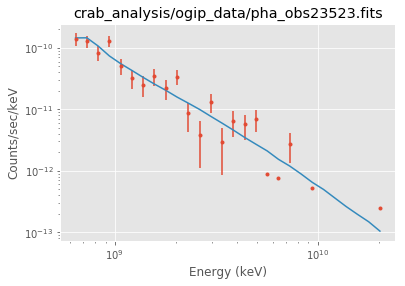

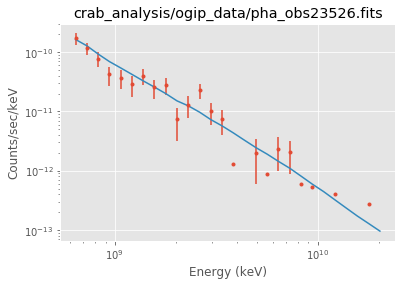

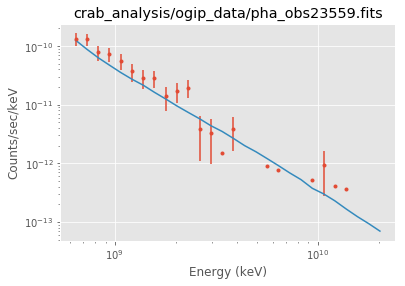

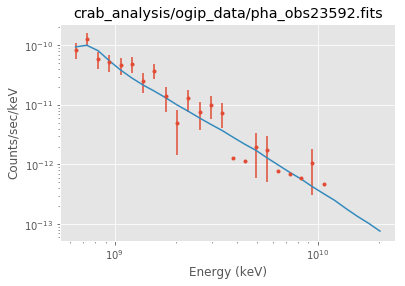

In [5]:
sh.get_data_plot_prefs()["xlog"] = True
sh.get_data_plot_prefs()["ylog"] = True
ds.plot_fit()

## Errors and confidence contours

We use [conf](http://cxc.harvard.edu/sherpa/ahelp/conf.html) and [reg_proj](http://cxc.harvard.edu/sherpa/ahelp/reg_proj.html) functions.

In [6]:
### Compute confidnce intervals
ds.conf()

p1.gamma lower bound:	-0.057005
p1.ampl lower bound:	-1.12614e-21
p1.ampl upper bound:	1.16189e-21
p1.gamma upper bound:	0.0582552
Datasets              = 1, 2, 3, 4
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = wstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   p1.gamma          2.43652    -0.057005    0.0582552
   p1.ampl        2.3608e-20 -1.12614e-21  1.16189e-21


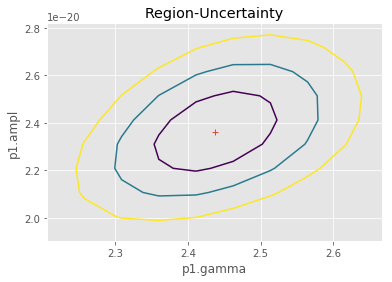

In [7]:
### Compute confidence contours for amplitude and index
sh.reg_unc(p1.gamma,p1.ampl)